# Denoise picture

Denoise the picture

## Load data

In [1]:
import numpy as np
from PIL import Image
import os

In [2]:
#Data loading
dataPath = "D:/Project/DeepLearning/denoisedZoomPicture/Data/"

#xtrain
file = open(dataPath + 'train.txt' , 'r')
train = file.readlines()
file.close()

train= list(map(lambda s: s[:-1]  ,train))


xtr = list()
ytr = list()
for f in train:
    # Loop through train and load the picture
    xtr.append( np.load(dataPath + 'X/' + f)  )
    ytr.append( np.load(dataPath + 'Y/' + f)  )

file = open(dataPath + 'test.txt' , 'r')
test = file.readlines()
file.close()

test= list(map(lambda s: s[:-1]  ,test))
xtest = list()
ytest = list()
for f in test:
    # Loop through test and load the picture
    xtest.append( np.load(dataPath + 'X/' + f)  )
    ytest.append( np.load(dataPath + 'Y/' + f)  )

del train, test

In [3]:
#Data reshaping

xtr = np.asarray(xtr)/255
ytr = np.asarray(ytr)/255

xtest = np.asarray(xtest)/255
ytest = np.asarray(ytest)/255

xtr = xtr.flatten()
xtr = xtr.reshape(-1,200,200,3)
xtest = xtest.flatten()
xtest = xtest.reshape(-1,200,200,3)

ytr = ytr.flatten()
ytr = ytr.reshape(-1,200,200,3)
ytest = ytest.flatten()
ytest = ytest.reshape(-1,200,200,3)

In [4]:
#View the picture
def viewPics(X,Y):
    """this function show both X and Y picture"""
    i = np.random.randint(0,len(X))
    x = X[i] * 255
    y = Y[i] * 255
    x = x.astype('uint8')
    y = y.astype('uint8')
    mtr = np.concatenate([x,y], axis=1)
    img = Image.fromarray(mtr)
    return(img)

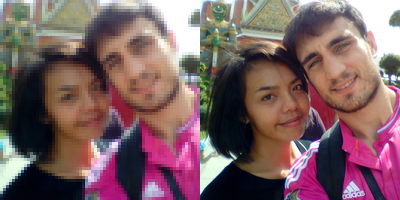

In [5]:
viewPics(xtr,ytr)

## Model Creation

Lets use almost the same autoencoder we use for color the black and white pictures

In [6]:
from keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPool2D, Input, Conv2DTranspose, BatchNormalization
from keras.backend import int_shape
from keras.models import Model
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [7]:
vgg16 = VGG16(include_top=False, weights='imagenet' ,input_tensor=None,  pooling=None, input_shape=(200,200,3), classes=1000)

In [8]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [10]:
#Model Creation

inputs = Input(name='Model2_Input', shape=(200,200,3)  )

x = inputs

#add vgg16 layers
for lyr in vgg16.layers[:-10]:
    x = lyr(x)
    x.trainable=False


    
x = BatchNormalization()(x)
x = Conv2DTranspose(kernel_size=3,activation='relu',strides = 2 , padding='same',filters=128)(x)
x = MaxPool2D(2)(x)


x = Conv2DTranspose(kernel_size=3,activation='relu',strides = 2 , padding='same',filters=64)(x)

x = Conv2DTranspose(kernel_size=3,activation='relu',strides = 2 , padding='same',filters=3)(x)


model = Model(inputs, x, name='model2')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Model2_Input (InputLayer)    (None, 200, 200, 3)       0         
_________________________________________________________________
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
__________

In [12]:
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

In [13]:
epochStart = 1
epochEnd = 50
step = 5
pathRoot = "D:/Project/DeepLearning/denoisedZoomPicture/"

In [14]:
# Create X and Y picture
os.mkdir( pathRoot + 'outputs/Model/test')
os.mkdir( pathRoot + 'outputs/Model/train')

index = 0
for p in xtr[:20]:
    pp = p * 255
    pp = pp.astype('uint8')
    z = Image.fromarray(pp)
    z.save(pathRoot + 'outputs/Model/train/photo{}_X.png'.format(index))
    index += 1

index = 0    
for p in ytr[:20]:
    pp = p * 255
    pp = pp.astype('uint8')
    z = Image.fromarray(pp)
    z.save(pathRoot + 'outputs/Model/train/photo{}_Y.png'.format(index))
    index += 1    
    
index = 0
for p in xtest[:20]:
    pp = p * 255
    pp = pp.astype('uint8')
    z = Image.fromarray(pp)
    z.save(pathRoot + 'outputs/Model/test/photo{}_X.png'.format(index))
    index += 1 

index = 0
for p in ytest[:20]:
    pp = p * 255
    pp = pp.astype('uint8')
    z = Image.fromarray(pp)
    z.save(pathRoot + 'outputs/Model/test/photo{}_Y.png'.format(index))
    index += 1 

In [15]:
from keras.callbacks import TensorBoard
tbd = TensorBoard("D:/Project/DeepLearning/denoisedZoomPicture/outputs/log")

In [16]:
#Loop through epoch and very step epochs save the model, and genrate some picture

for ep in range(epochStart,epochEnd,step):
    
    #===============Train the model=======================================
    model.fit(xtr,ytr,batch_size=15,callbacks=[tbd],validation_data=(xtest,ytest) ,initial_epoch=ep ,epochs= ep+step)
    
    #==================Save the model=========================================
    os.mkdir( pathRoot + 'models/model/Epoch{}'.format(ep + step))#create the folder
    model.save( pathRoot + "models/model/Epoch{}/model{}.h5".format(ep + step,ep + step))
    
    #==================Create output data=====================================
    os.mkdir( pathRoot + 'outputs/Model/Epoch{}'.format(ep + step))
    os.mkdir( pathRoot + 'outputs/Model/Epoch{}/test'.format(ep + step))
    os.mkdir( pathRoot + 'outputs/Model/Epoch{}/train'.format(ep + step))
    
    
    #export the genrated pictures (test)
    res = model.predict(xtest[0:20])
    res *= 255
    res = res.astype('uint8')

    index = 1
    for img in res:
        z = Image.fromarray( img )
        z.save( pathRoot + 'outputs/Model/Epoch{}/test/Photo{}.png'.format(ep + step,index))
        index += 1
    
    #export the genrated pictures (train)
    res = model.predict(xtr[0:20])
    res *= 255
    res = res.astype('uint8')
    index = 1
    for img in res:
        z = Image.fromarray( img )
        z.save( pathRoot + 'outputs/Model/Epoch{}/train/Photo{}.png'.format(ep + step,index))
        index += 1
    